In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import argparse
import breizhcrops
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [4]:
print(torch.__version__)

1.6.0


In [5]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# Define params and datapath

In [6]:
# insert breizhcrops dataset path
abs_path= '/home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset'
# path = '.../breizhcrops_dataset'
datapath = Path(abs_path)
print(datapath)
mode = 'all_zones'
batch_size = 256
learning_rate = 0.001

weight_decay = 5e-08
workers = 0

/home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset


# Define Dataloader

In [7]:
from utils.data_load import *
from utils.metrics import metrics

In [8]:
# if we want to import all zones data
zone1dataset, zone2dataset, zone3dataset, zone4dataset, meta = get_datasets(datapath=datapath, mode=mode,
                                                        batchsize=batch_size, 
                                                        preload_ram=True, level="L2A")

loading data into RAM:   0%|          | 0/178632 [00:00<?, ?it/s]

Setting up datasets in /home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset, level L2A


loading data into RAM: 100%|██████████| 122708/122708 [00:33<00:00, 3610.61it/s]


In [9]:
num_classes = meta["num_classes"]
ndims = meta["ndims"]
sequencelength = meta["sequencelength"]

In [23]:
zone1dataloader, zone2dataloader, zone3dataloader, zone4dataloader = get_dataloader2(zone1dataset, zone2dataset, 
                                                                                     zone3dataset, zone4dataset,
                                                                                     batchsize=batch_size, 
                                                                                     workers=workers)

# Define DANN Transformer

In [11]:
# Transformer params
#ndims=10
#num_classes=9
#sequencelength=45
        
d_model=64
n_head=2
n_layers=3
d_inner=128

In [12]:
from utils.DANN_Transformer_model import ViTransformerExtractor, ViTransformerDANN

feature_ex = ViTransformerExtractor(input_dim=ndims, n_head=n_head, n_layers=n_layers, 
                                    activation="relu",).to(device)
dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes, n_layers = n_layers, 
                                    n_domain=2,
                                    activation="relu",).to(device)

dann_model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
print(f"Initialized {dann_model.modelname}")

logdir = 'logs/torch_transformer_dann/'

print(f"Initialized {dann_model.modelname}")
os.makedirs(logdir, exist_ok=True)
print(f"Logging results to {logdir}")

Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08
Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08
Logging results to logs/torch_transformer_dann/


# Feature Visualization

# 2D Features plot

In [ ]:
# DEFINE SOURCE AND TARGET ZONE DATA
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
num_categories = 9
alpha_c = 0.2
gamma = 10

source = 1
target = 2

traindataloader = dataloaders[source][0]
train_zone = dataloaders[source][1]
print('Training zone:', train_zone)

testdl = dataloaders[target][0]
test_zone = dataloaders[target][1]
print('Testing zone:', test_zone)
source_zone = train_zone
target_zone = test_zone

# LOAD MODEL WEIGHTS
path = 'models/vio_trasformer_dann_s2_t3_maxalpha02_gamma10/archive.zip'
#path = 'models/torch_transformer/vio_trasformer_dann_s'+str(source+1)+'_t'+ str(target+1)+'_gamma'+str(gamma)
#path = 'models/torch_transformer/vio_trasformer_dann_s'+str(source+1)+'_t'+ str(target+1)+'_maxalpha02_gamma'+str(gamma)
model_dir = Path(path)
dann_model.load_state_dict(torch.load(model_dir))

  0%|          | 2/550 [00:00<00:43, 12.59it/s]

Training zone: zone2
Testing zone: zone3


100%|██████████| 550/550 [00:43<00:00, 12.71it/s]


Extracted embedded features shape (140782, 64)


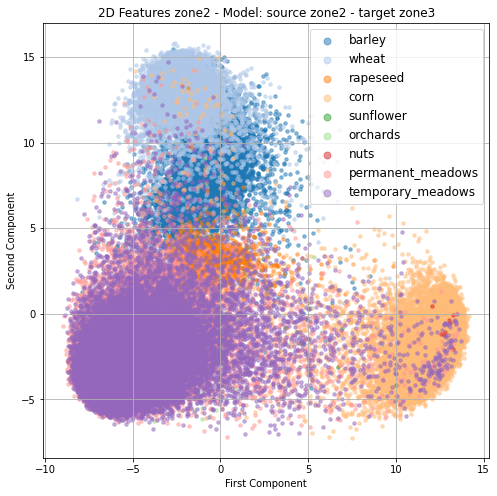

100%|██████████| 650/650 [00:52<00:00, 12.30it/s]


Extracted embedded features shape (166367, 64)


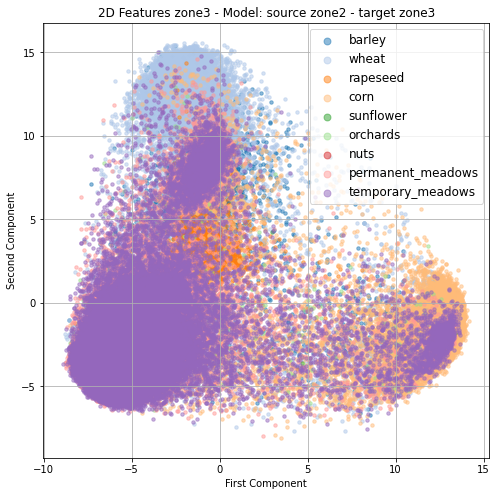

In [17]:
from utils.visualize_results import extract_features, plot2Dpca

# EXTRACT FEATURES AND PLOT 2D
train_embeddings, train_targets, train_predictions = extract_features(dann_model, traindataloader, device)
pca_train_embs = plot2Dpca(train_zone, source_zone, target_zone, train_embeddings, train_targets, train_predictions, save_plot = True)

test_embeddings, test_targets, test_predictions = extract_features(dann_model, testdl, device)
pca_test_embs = plot2Dpca(test_zone, source_zone, target_zone, test_embeddings, test_targets, test_predictions, save_plot = True)

# Compute MMD metric

In [35]:
# Reduce dataset size to compute MMD in case of low memory resources
from utils.data_load import reduce_random_dataset
zones = 4
full_datasets = [zone1dataset, zone2dataset, zone3dataset, zone4dataset]
new_datasets = []
for i in range(zones):
    print('Full Dataset {} len: '.format(str(i+1)), full_datasets[i].__len__())
    new = reduce_random_dataset(full_datasets[i], 500)
    new_datasets.append(new)
    print('Reduced Dataset {} len: '.format(str(i+1)), new.__len__())

zone1dataset_new = new_datasets[0]
zone2dataset_new = new_datasets[1]
zone3dataset_new = new_datasets[2]
zone4dataset_new = new_datasets[3]

Full Dataset 1 len:  178632
Reduced Dataset 1 len:  500
Full Dataset 2 len:  140782
Reduced Dataset 2 len:  500
Full Dataset 3 len:  166367
Reduced Dataset 3 len:  500
Full Dataset 4 len:  122708
Reduced Dataset 4 len:  500


In [36]:
zone1dataloader, zone2dataloader, zone3dataloader, zone4dataloader = get_dataloader2(zone1dataset, zone2dataset, 
                                                                                     zone3dataset, zone4dataset,
                                                                                     batchsize=batch_size, 
                                                                                     workers=workers)

In [ ]:
from utils.metrics import MMD

train_embeddings, train_targets, train_predictions = extract_features(dann_model, traindataloader, device)
test_embeddings, test_targets, test_predictions = extract_features(dann_model, testdl, device)

train_embs = torch.as_tensor(train_embeddings)
test_embs = torch.as_tensor(test_embeddings)

mmd = MMD(train_embs, test_embs, 'rbf')
mmd = mmd.detach().cpu().numpy()
print('MMD for source zone {} - target zone {}: '.format(str(source+1), str(target+1)), mmd)
mmd_results.append(mmd)
mmd_results = np.asarray(mmd_results)
print('MMD results for zone {}: '.format(str(source+1)), mmd_results)

# save results
np.save('results/'+train_zone+'/MMD_results_zone{}'.format(str(source+1)), mmd_results)

# 3D features plot

In [ ]:
# PRINT 3D comparison of best and worst case
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
num_categories = 9
gamma = 10

# SELECT Source AND Target DOMAIN (REGION) to identify the model
# Source
source = 1 #zone number = i+1
# Target
target = 2 #zone number = i+1
sourcedataloader = dataloaders[source][0]
source_zone = dataloaders[source][1]
print('Source zone:', source_zone)
    
targetdl = dataloaders[target][0]
target_zone = dataloaders[target][1]
print('Target zone:', target_zone)

#BEST DANN MODEL = 2 --> 3 
path = 'models/vio_trasformer_dann_s2_t3_maxalpha02_gamma10/archive.zip'
#path = 'models/torch_transformer/vio_trasformer_dann_s'+str(source+1)+'_t'+ str(target+1)+'_gamma'+str(gamma)
model_dir = Path(path)
dann_model.load_state_dict(torch.load(model_dir))

  0%|          | 2/550 [00:00<00:43, 12.66it/s]

Source zone: zone2
Target zone: zone3


  0%|          | 2/650 [00:00<00:51, 12.49it/s]

Extracted embedded features shape (140782, 64)


100%|██████████| 650/650 [00:52<00:00, 12.43it/s]


Extracted embedded features shape (166367, 64)


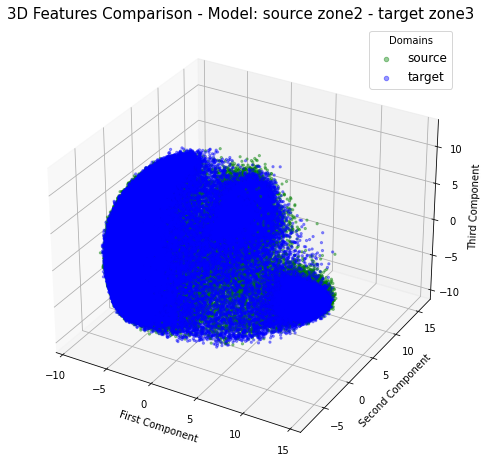

In [25]:
from utils.visualize_results import extract_features, plot3Dpca, plot3D_source_target

source_embeddings, source_targets, source_predictions = extract_features(dann_model, sourcedataloader, device)
target_embeddings, target_targets, target_predictions = extract_features(dann_model, targetdl, device)

image_name = '3Dfeature_pca_'+source_zone+target_zone
plot3D_source_target(source_zone, target_zone, 
                     source_embeddings, source_targets, source_predictions,
                     target_embeddings, target_targets, target_predictions,
                     image_name,
                     save_plot = True)